In [16]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import calendar


## 1. Who are the winners of the D1 division in the Germany Football Association (Bundesliga) in the last decade?

In [2]:
spark = SparkSession.builder.appName('firstSpark').getOrCreate()

In [3]:
def load_dataframe(filename):
    df = spark.read.format('csv').options(header='true').load(filename)
    return df

In [4]:
df_matches = load_dataframe('Data/Matches.csv')
df_matches.limit(5).show()

+--------+---+------+----------+-------------+--------------+----+----+---+
|Match_ID|Div|Season|      Date|     HomeTeam|      AwayTeam|FTHG|FTAG|FTR|
+--------+---+------+----------+-------------+--------------+----+----+---+
|       1| D2|  2009|2010-04-04|   Oberhausen|Kaiserslautern|   2|   1|  H|
|       2| D2|  2009|2009-11-01|  Munich 1860|Kaiserslautern|   0|   1|  A|
|       3| D2|  2009|2009-10-04|Frankfurt FSV|Kaiserslautern|   1|   1|  D|
|       4| D2|  2009|2010-02-21|Frankfurt FSV|     Karlsruhe|   2|   1|  H|
|       5| D2|  2009|2009-12-06|        Ahlen|     Karlsruhe|   1|   3|  A|
+--------+---+------+----------+-------------+--------------+----+----+---+



In [5]:
old_cols = df_matches.columns[-3:]
new_cols = ["HomeTeamGoals", "AwayTeamGoals", "FinalResult"]
old_new_cols = [*zip(old_cols, new_cols)]
for old_col, new_col in old_new_cols:
    df_matches = df_matches.withColumnRenamed(old_col, new_col)

In [6]:
df_matches.limit(5).toPandas()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,HomeTeamGoals,AwayTeamGoals,FinalResult
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A


In [31]:
df_matches = df_matches.withColumn('HomeTeamWin', when(col('FinalResult') == 'H', 1).otherwise(0)).withColumn('AwayTeamWin', when(col('FinalResult') == 'A', 1).otherwise(0)).withColumn('GameTie', when(col('FinalResult') == 'D', 1).otherwise(0))


bundesliga = df_matches.filter((col('Season') >= 2000) & (col('Season') <= 2010) & (col('Div') == 'D1'))

# home team features
home = bundesliga.groupby('Season', 'HomeTeam') \
       .agg(sum('HomeTeamWin').alias('TotalHomeWin'),
            sum('AwayTeamWin').alias('TotalHomeLoss'),
            sum('GameTie').alias('TotalHomeTie'),
            sum('HomeTeamGoals').alias('HomeScoredGoals'),
            sum('AwayTeamGoals').alias('HomeAgainstGoals')) \
       .withColumnRenamed('HomeTeam', 'Team')

#away game features 
away =  bundesliga.groupby('Season', 'AwayTeam') \
       .agg(sum('AwayTeamWin').alias('TotalAwayWin'),
            sum('HomeTeamWin').alias('TotalAwayLoss'),
            sum('GameTie').alias('TotalAwayTie'),
            sum('AwayTeamGoals').alias('AwayScoredGoals'),
            sum('HomeTeamGoals').alias('AwayAgainstGoals'))  \
       .withColumnRenamed('AwayTeam', 'Team')

#season features
window = ['Season']
window = Window.partitionBy(window).orderBy(col('WinPct').desc(), col('GoalDifferentials').desc())
table = home.join(away, ['Team', 'Season'],  'inner') \
    .withColumn('GoalsScored', col('HomeScoredGoals') + col('AwayScoredGoals')) \
    .withColumn('GoalsAgainst', col('HomeAgainstGoals') + col('AwayAgainstGoals')) \
    .withColumn('GoalDifferentials', col('GoalsScored') - col('GoalsAgainst')) \
    .withColumn('Win', col('TotalHomeWin') + col('TotalAwayWin')) \
    .withColumn('Loss', col('TotalHomeLoss') + col('TotalAwayLoss')) \
    .withColumn('Tie', col('TotalHomeTie') + col('TotalAwayTie')) \
    .withColumn('WinPct', round((100* col('Win')/(col('Win') + col('Loss') + col('Tie'))), 2)) \
    .drop('HomeScoredGoals', 'AwayScoredGoals', 'HomeAgainstGoals', 'AwayAgainstGoals') \
    .drop('TotalHomeWin', 'TotalAwayWin', 'TotalHomeLoss', 'TotalAwayLoss', 'TotalHomeTie', 'TotalAwayTie') \
    .withColumn('TeamPosition', rank().over(window)) 

table_df = table.filter(col('TeamPosition') == 1).orderBy(asc('Season')).toPandas()
table_df

,Team,Season,GoalsScored,GoalsAgainst,GoalDifferentials,Win,Loss,Tie,WinPct,TeamPosition
0,Bayern Munich,2000,62.0,37.0,25.0,19,9,6,55.88,1
1,Leverkusen,2001,77.0,38.0,39.0,21,7,6,61.76,1
2,Bayern Munich,2002,70.0,25.0,45.0,23,5,6,67.65,1
3,Werder Bremen,2003,79.0,38.0,41.0,22,4,8,64.71,1
4,Bayern Munich,2004,75.0,33.0,42.0,24,5,5,70.59,1
5,Bayern Munich,2005,67.0,32.0,35.0,22,3,9,64.71,1
6,Stuttgart,2006,61.0,37.0,24.0,21,6,7,61.76,1
7,Bayern Munich,2007,68.0,21.0,47.0,22,2,10,64.71,1
8,Wolfsburg,2008,80.0,41.0,39.0,21,7,6,61.76,1
9,Bayern Munich,2009,72.0,31.0,41.0,20,4,10,58.82,1


In [9]:

table.filter(col('TeamPosition') == 1).orderBy(asc('Season')).groupby('Team').agg(count('Team').alias("TotalChampionships"),
                          avg('WinPct').alias('AvgWinPct'),
                          avg('GoalDifferentials').alias('AvgGD'),
                          avg('Win').alias('AvgWin'),
                          avg('Loss').alias('AvgLoss'),
                          avg('Tie').alias('AvgTie')) \
    .orderBy(desc("TotalChampionships")).toPandas().round(1)


,Team,TotalChampionships,AvgWinPct,AvgGD,AvgWin,AvgLoss,AvgTie
0,Bayern Munich,6,63.7,39.2,21.7,4.7,7.7
1,Werder Bremen,1,64.7,41.0,22.0,4.0,8.0
2,Leverkusen,1,61.8,39.0,21.0,7.0,6.0
3,Wolfsburg,1,61.8,39.0,21.0,7.0,6.0
4,Stuttgart,1,61.8,24.0,21.0,6.0,7.0
5,Dortmund,1,67.6,45.0,23.0,5.0,6.0


## 2. Which teams have been relegated in the past 10 years?

In [57]:
for year in range(2000, 2011):
    print(f"Team relegated in {year}:")
    df = table.filter(col('Season') == year).toPandas()[-2:]
    for index, row in df.iterrows():
        print('\t',row['Team'])
    
    

Team relegated in 2000:
	 Unterhaching
	 Bochum
Team relegated in 2001:
	 FC Koln
	 St Pauli
Team relegated in 2002:
	 Nurnberg
	 Cottbus
Team relegated in 2003:
	 Munich 1860
	 FC Koln
Team relegated in 2004:
	 Hansa Rostock
	 Freiburg
Team relegated in 2005:
	 Wolfsburg
	 Duisburg
Team relegated in 2006:
	 Mainz
	 M'gladbach
Team relegated in 2007:
	 Bielefeld
	 Nurnberg
Team relegated in 2008:
	 Bochum
	 Bielefeld
Team relegated in 2009:
	 Bochum
	 Hertha
Team relegated in 2010:
	 Ein Frankfurt
	 St Pauli


## 3. Does Octoberfest affect the performance of Bundesliga?

In [32]:
matches_by_months = df_matches.filter(col('Div') == 'D1').filter((col('Season') >= 2000) &(col('Season') <= 2010)) \
                .withColumn('Month', month(col('Date')))
matches_by_months.toPandas().head()


,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,HomeTeamGoals,AwayTeamGoals,FinalResult,HomeTeamWin,AwayTeamWin,GameTie,Month
0,21,D1,2009,2010-02-06,Bochum,Leverkusen,1,1,D,0,0,1,2
1,22,D1,2009,2009-11-22,Bayern Munich,Leverkusen,1,1,D,0,0,1,11
2,23,D1,2009,2010-05-08,M'gladbach,Leverkusen,1,1,D,0,0,1,5
3,24,D1,2009,2009-08-08,Mainz,Leverkusen,2,2,D,0,0,1,8
4,25,D1,2009,2009-10-17,Hamburg,Leverkusen,0,0,D,0,0,1,10


In [33]:
result = matches_by_months.groupby('Month').agg(sum(col('HomeTeamGoals') + col('AwayTeamGoals'))
                                                .alias('TotalGoals'),count(col('GameTie')).alias('Total'))
result.toPandas().head()

,Month,TotalGoals,Total
0,12,813.0,290
1,1,386.0,140
2,3,1076.0,386
3,5,993.0,308
4,9,1027.0,364


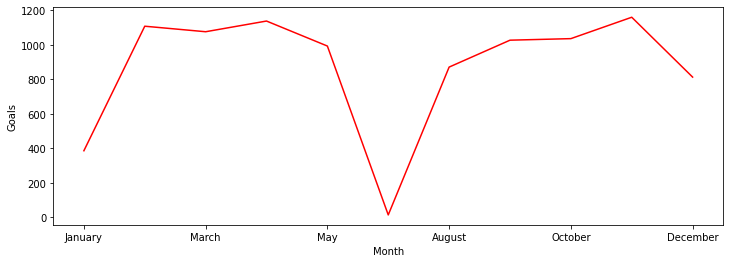

In [34]:
df = result.toPandas().sort_values('Month')
df['Month'] = [calendar.month_name[val] for val in df.Month.tolist()]
df.set_index('Month', drop=True, inplace=True)
df['TotalGoals'].plot(rot=0, color='red', figsize=(12, 4))
plt.ylabel('Goals')

plt.show()

## 4.Which season of Bundesliga was the most competitive in the last decade?


In [35]:
matches_by_months = df_matches.filter(col('Div') == 'D1').filter((col('Season') >= 2000) &(col('Season') <= 2010))
matches_by_months.toPandas()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,HomeTeamGoals,AwayTeamGoals,FinalResult,HomeTeamWin,AwayTeamWin,GameTie
0,21,D1,2009,2010-02-06,Bochum,Leverkusen,1,1,D,0,0,1
1,22,D1,2009,2009-11-22,Bayern Munich,Leverkusen,1,1,D,0,0,1
2,23,D1,2009,2010-05-08,M'gladbach,Leverkusen,1,1,D,0,0,1
3,24,D1,2009,2009-08-08,Mainz,Leverkusen,2,2,D,0,0,1
4,25,D1,2009,2009-10-17,Hamburg,Leverkusen,0,0,D,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3361,37179,D1,2004,2005-05-21,Hertha,Hannover,0,0,D,0,0,1
3362,37180,D1,2004,2005-05-21,Kaiserslautern,Werder Bremen,1,2,A,0,1,0
3363,37181,D1,2004,2005-05-21,Leverkusen,M'gladbach,5,1,H,1,0,0
3364,37182,D1,2004,2005-05-21,Nurnberg,Mainz,1,2,A,0,1,0


In [36]:
result = matches_by_months.groupby('Season').agg(sum(col('HomeTeamGoals') + col('AwayTeamGoals'))
                                                .alias('TotalGoals'),count(col('GameTie')).alias('Total'))
result.toPandas().head()

,Season,TotalGoals,Total
0,2005,861.0,306
1,2000,897.0,306
2,2002,821.0,306
3,2009,866.0,306
4,2006,837.0,306


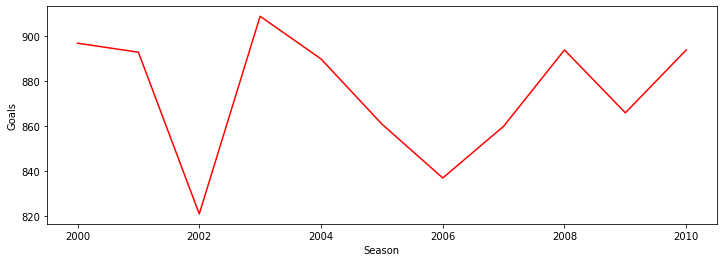

In [38]:
df = result.toPandas().sort_values('Season')
df.set_index('Season', drop=True, inplace=True)
df['TotalGoals'].plot(rot=0, color='red', figsize=(12, 4))
plt.ylabel('Goals')

plt.show()

## 5.What's the best month to watch Bundesliga?

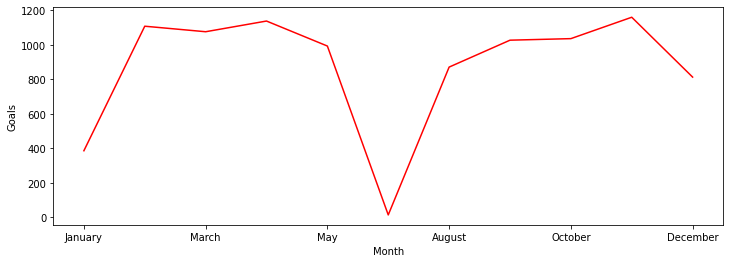

In [39]:
matches_by_months = df_matches.filter(col('Div') == 'D1').filter((col('Season') >= 2000) &(col('Season') <= 2010)) \
                .withColumn('Month', month(col('Date')))

result = matches_by_months.groupby('Month').agg(sum(col('HomeTeamGoals') + col('AwayTeamGoals'))
                                                .alias('TotalGoals'),count(col('GameTie')).alias('Total'))
df = result.toPandas().sort_values('Month')
df['Month'] = [calendar.month_name[val] for val in df.Month.tolist()]
df.set_index('Month', drop=True, inplace=True)
df['TotalGoals'].plot(rot=0, color='red', figsize=(12, 4))
plt.ylabel('Goals')

plt.show()